In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal, stats
from matplotlib import pyplot as plt

In [2]:
CAF_DOSE = 200
FREQUENCY = 256
SUBJECT_INDEX = 0
STAGE = 'REM'

SUBJECTS_PATH = 'E:\\Cafeine_data\\CAF_{dose}_Inventaire.csv'.format(dose=CAF_DOSE)
DATA_PATH = 'E:\\Cafeine_data\\CAF_{dose}\\EEG_data\\'.format(dose=CAF_DOSE)

BANDS = ['delta', 'theta', 'alpha', 'low beta', 'beta', 'low gamma']

In [3]:
def extract_sleep_stages(data, hypnogram):
    """
    Extracts sleep stages from EEG data using a hypnogram, epochs from the same sleep stage are grouped.
    
    Args:
        data: EEG data as (electrodes x epoch steps x epochs)
    
    Returns:
        dictionary with sleep stage names as keys and EEG epochs as values with shape (electrodes x epoch steps x epochs)
    """    
    if data.shape[2] != hypnogram.shape[0]:
        # the epoch count does not match the hypnogram length, adjusting EEG data shape
        print(f'WARNING: eeg epochs didn\'t match the hypnogram length ({data.shape[2]} and {hypnogram.shape[0]})')
        data = data[:,:,:hypnogram.shape[0]]

    # create a dictionary with entries for each sleep stage
    return {'AWA': data[:,:,hypnogram==0],
            'N1': data[:,:,hypnogram==1],
            'N2': data[:,:,hypnogram==2],
            'N3': data[:,:,(hypnogram==3)|(hypnogram==4)],
            'REM': data[:,:,hypnogram==5]}

# Loading the EEG data

In [4]:
subjects = pd.read_csv(SUBJECTS_PATH, index_col=0)

print('Loading EEG data...')
data_path = os.path.join(DATA_PATH, subjects['Subject_id'][SUBJECT_INDEX], 'EEG_data_clean.npy')
data = np.load(data_path)

print('Loading hypnogram...')
hypnogram_path = os.path.join(DATA_PATH, subjects['Subject_id'][SUBJECT_INDEX], 'hyp_clean.npy')
hypnogram = np.load(hypnogram_path)

Loading EEG data...
Loading hypnogram...


In [5]:
stages = extract_sleep_stages(data, hypnogram)
print('Epochs for each sleep stage:')
print('\n'.join([f'{key:6}: {dat.shape[-1]}' for key, dat in stages.items()]))

Epochs for each sleep stage:
AWA   : 102
N1    : 133
N2    : 748
N3    : 30
REM   : 223


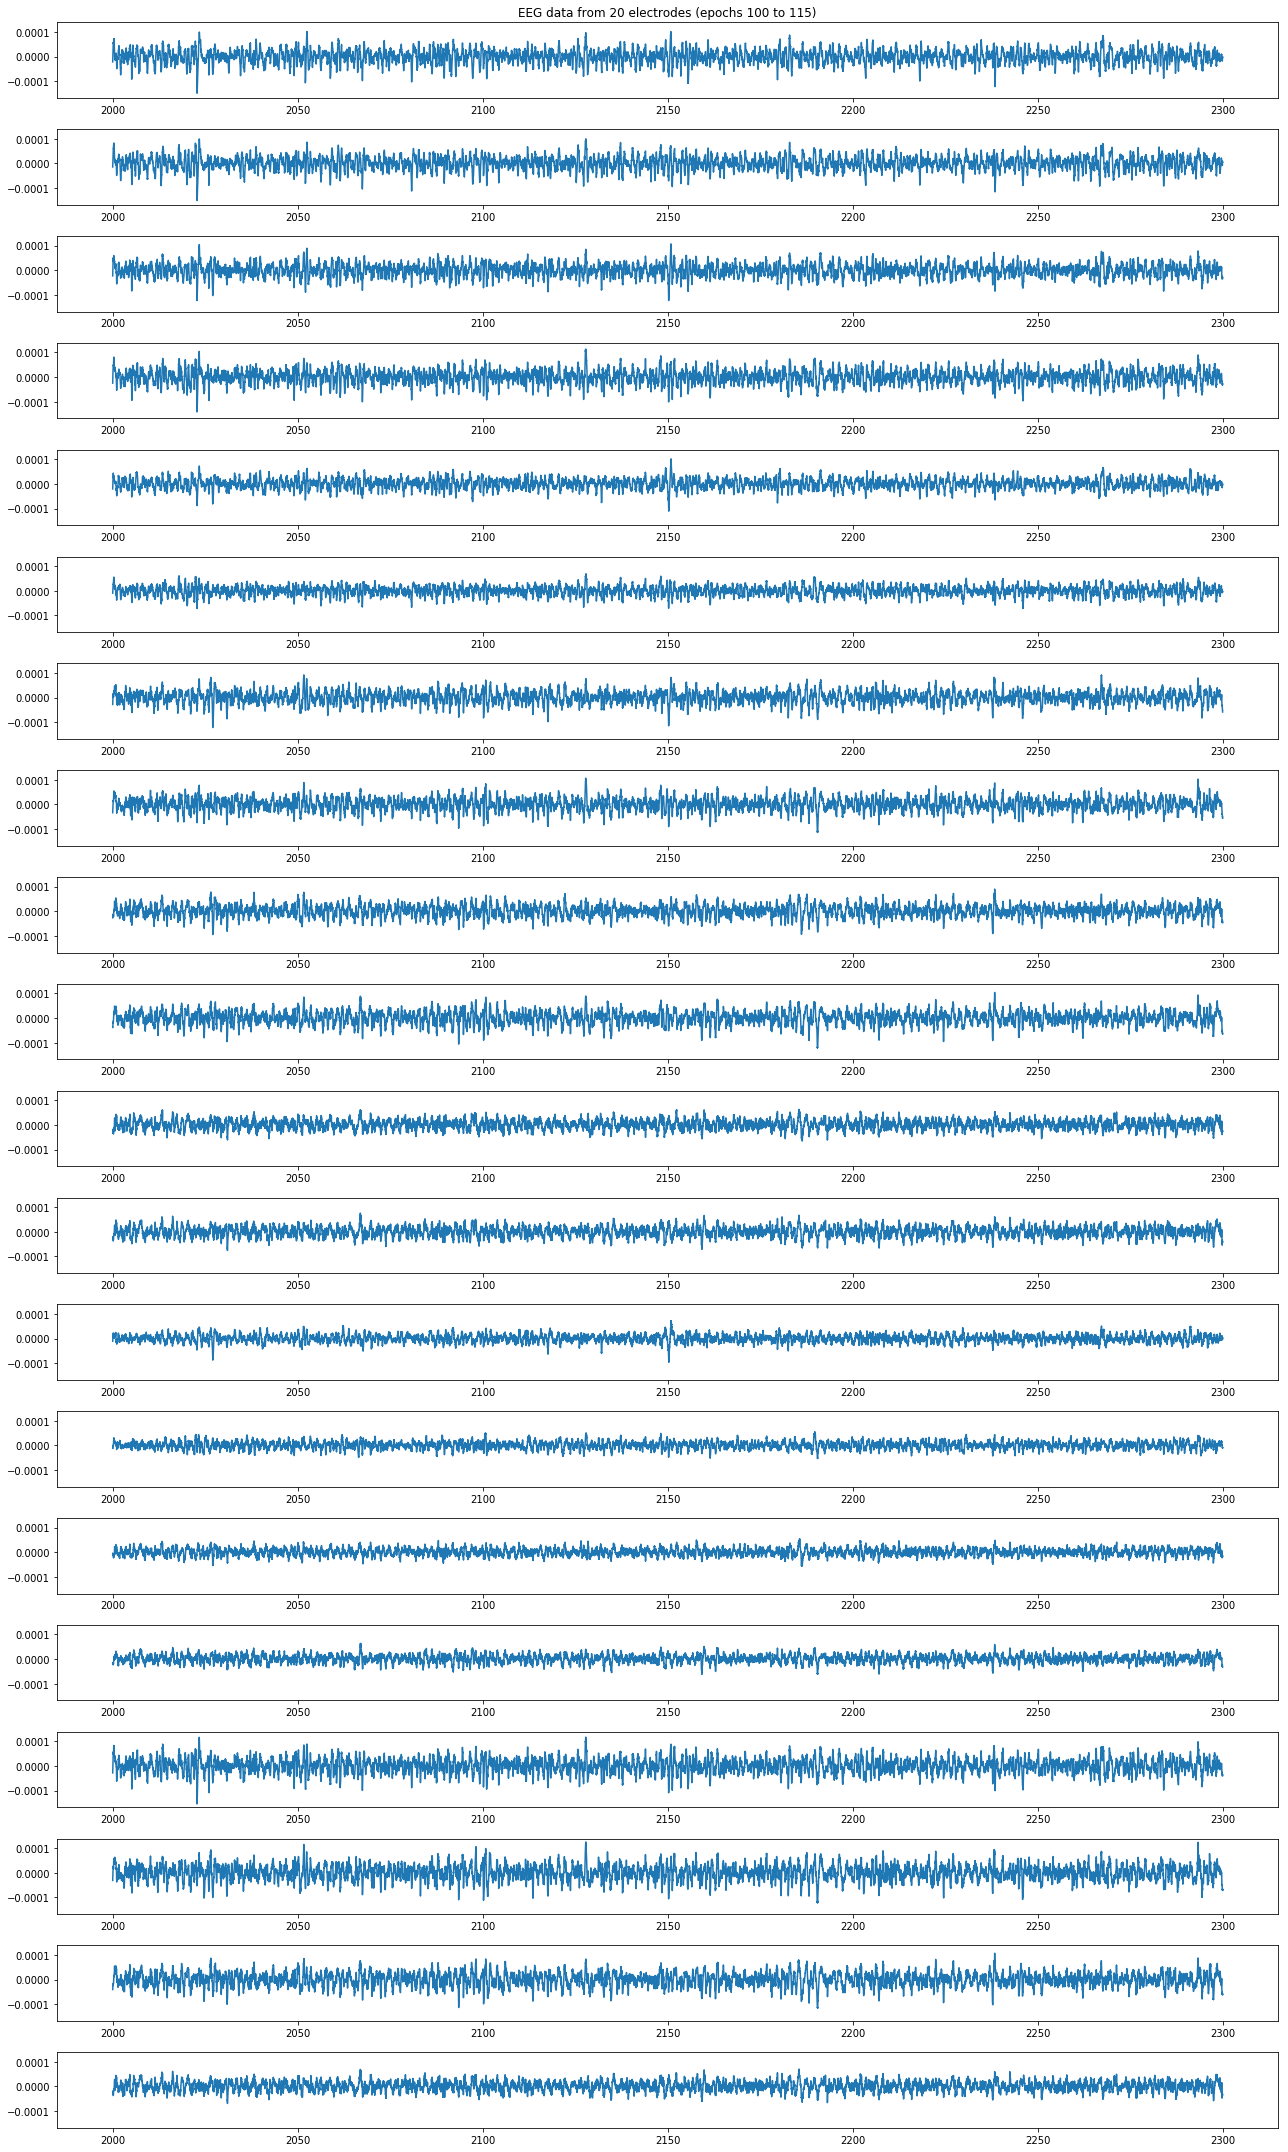

In [6]:
offset = 100
epochs = 15

last_ax = None
plt.figure(figsize=(18, 30))

for electrode in range(data.shape[0]):
    last_ax = plt.subplot(data.shape[0], 1, electrode + 1, sharex=last_ax, sharey=last_ax)
    if electrode == 0:
        plt.title(f'EEG data from {data.shape[0]} electrodes (epochs {offset} to {epochs + offset})')
    
    current = np.concatenate([data[electrode,:,i+offset] for i in range(epochs)])
    plt.plot(np.arange(offset * data.shape[1], current.shape[0] + offset * data.shape[1]) / FREQUENCY, current)
    
plt.tight_layout()
plt.show()

# Power spectral density

In [7]:
def _extract_frequency_power_bands(freqs, values, relative=False):
    """
    Extracts power of six frequency bands from a spectral distribution.
    
    Args:
        freqs: vector containing the discrete frequencies
        values: vector containing the spectral distribution
        relative: boolean indicating if the power bands should be a probability distribution or absolute sums
    
    Returns:
        list containing the power bands (delta, theta, alpha, low beta, remaining beta, low gamma)
    """
    if relative:
        total = np.sum(values)
    else:
        total = 1
    
    return [np.sum(values[(freqs>=0.3)&(freqs<4)]) / total,
            np.sum(values[(freqs>=4)&(freqs<8)]) / total,
            np.sum(values[(freqs>=8)&(freqs<12)]) / total,
            np.sum(values[(freqs>=12)&(freqs<16)]) / total,
            np.sum(values[(freqs>=16)&(freqs<32)]) / total,
            np.sum(values[(freqs>=32)&(freqs<=50)]) / total]

def _power_spectral_density_single_epoch(epoch, num_segments=6, frequency=256):
    """
    Computes the power spectral density for a single epoch with Welch's method.
    
    Args:
        epoch: vector with EEG data from one epoch
        num_windows: number of segments used in Welch's method
        frequency: sampling frequency of the EEG in Hz
    
    Returns:
        frequency distribution
        power spectral density
    """
    return signal.welch(epoch, fs=frequency, nperseg=len(epoch) // num_segments, noverlap=0, window='hamming')

def power_spectral_density(stage, bands=True, relative=False):
    """
    Computes the power spectral density for one sleep stage and (if bands is true) separates
    the spectrum into frequency bands.
    
    Args:
        stage: EEG data from one sleep stage (electrodes x epoch steps x epochs)
        bands: boolean indicating if PSD for frequency bands or complete PSD should be returned (changes output shape)
        relative: boolean idicating if the frequency power bands should be a probability distribution
    
    Returns:
        power spectral density (electrodes x epochs x amplitudes) or (electrodes x epochs x bands)
    """
    electrode_count = stage.shape[0]
    epoch_count = stage.shape[2]
    
    psd = []
    for electrode in range(electrode_count):
        # add a row for each electrode
        psd.append([])
        
        for epoch in range(epoch_count):
            # calculate PSD for the current epoch of the current electrode
            freq, amp = _power_spectral_density_single_epoch(stage[electrode,:,epoch])
            
            # add a column for each epoch
            psd[-1].append([])
            
            if bands:
                # add list with the power band values as the third dimension
                power_bands = _extract_frequency_power_bands(freq, amp, relative=relative)
                psd[-1][-1] = power_bands
            else:
                # add amplitude array as the third dimension
                psd[-1][-1] = amp
    
    return np.array(psd)

### Saved vs computed power spectral density comparison

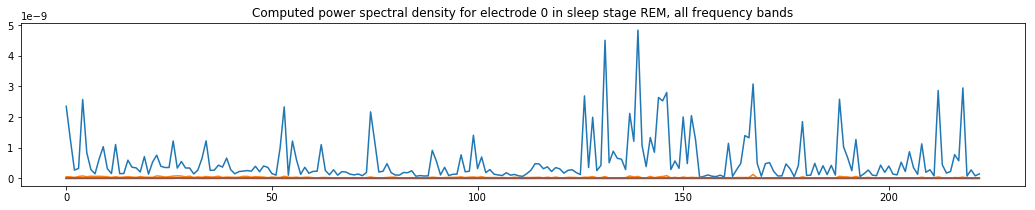

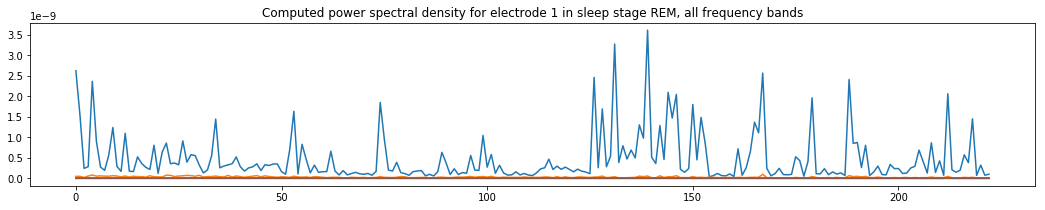

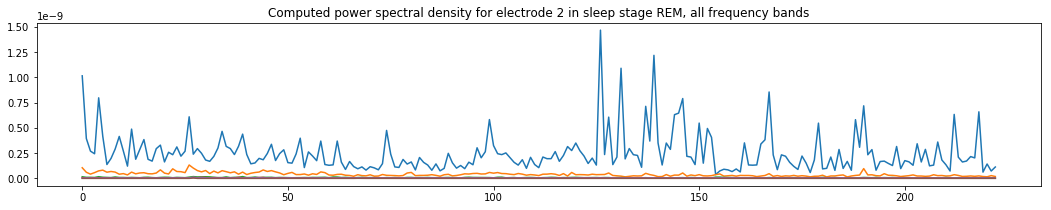

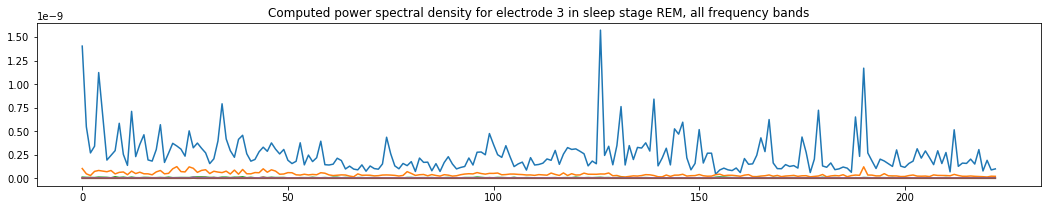

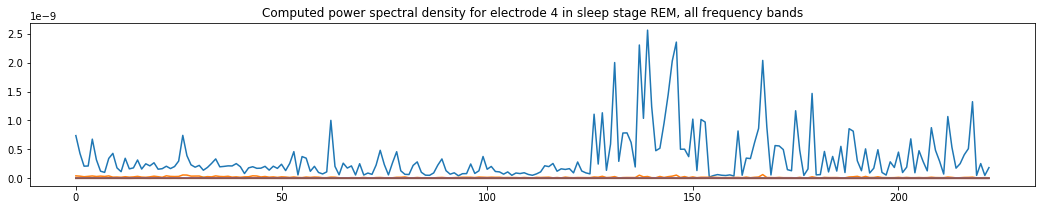

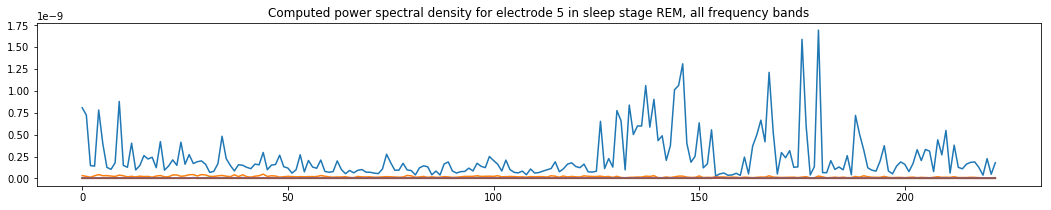

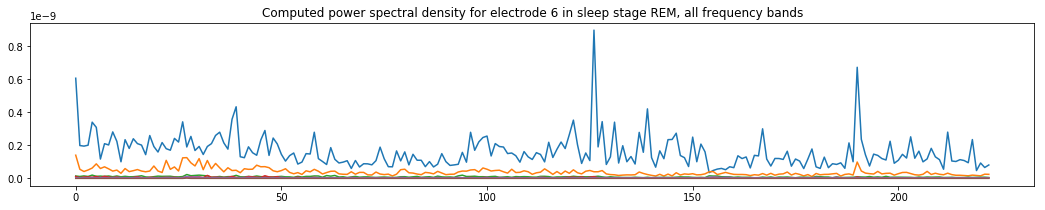

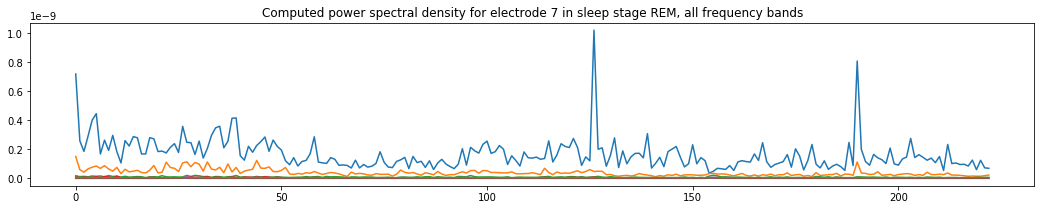

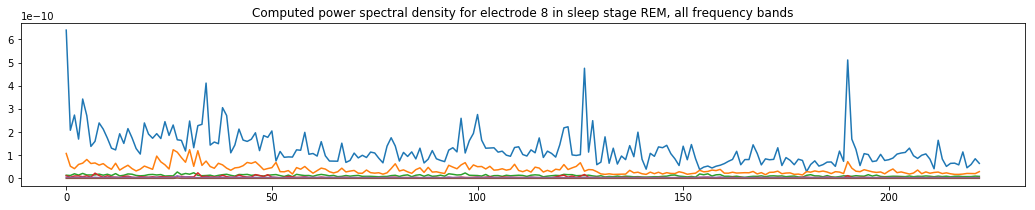

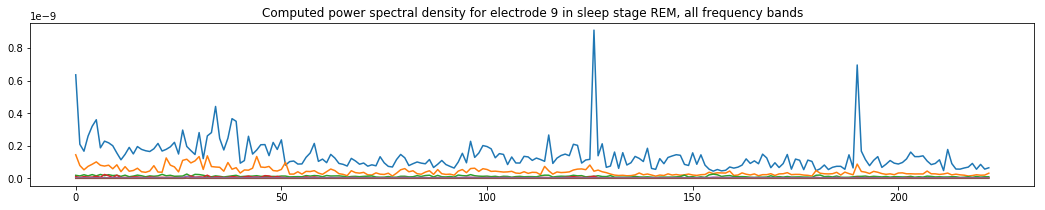

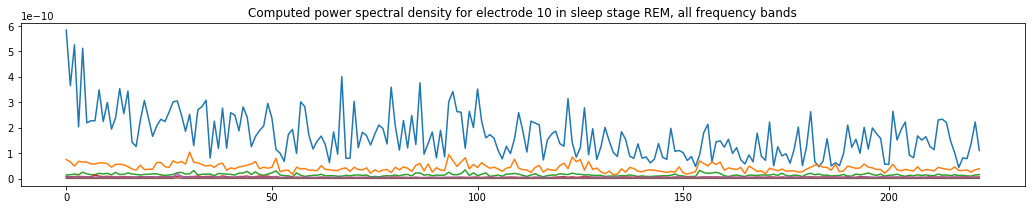

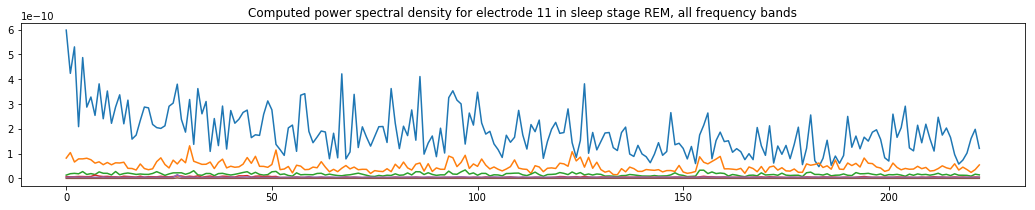

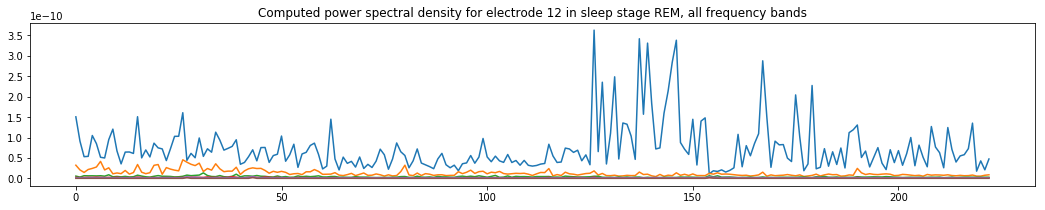

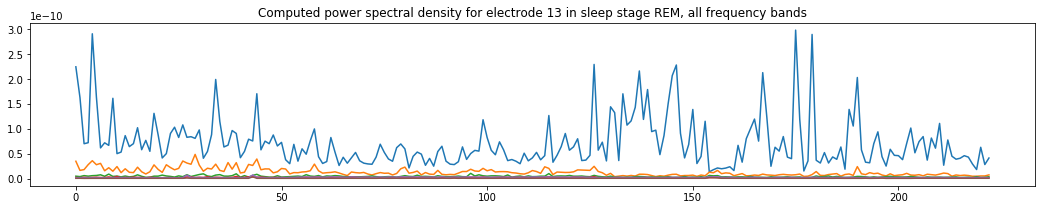

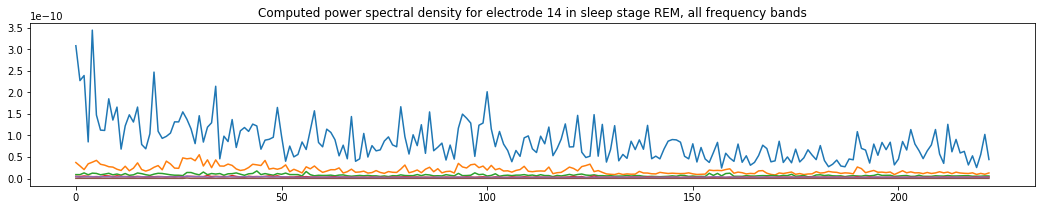

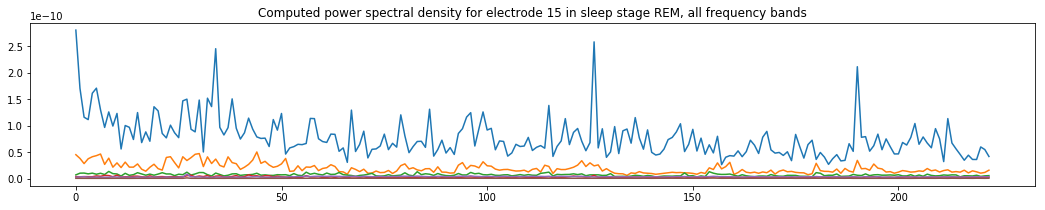

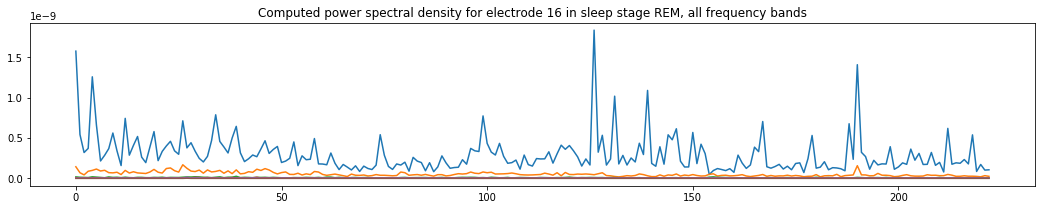

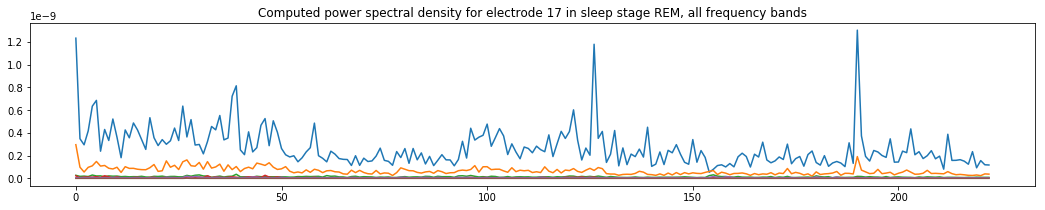

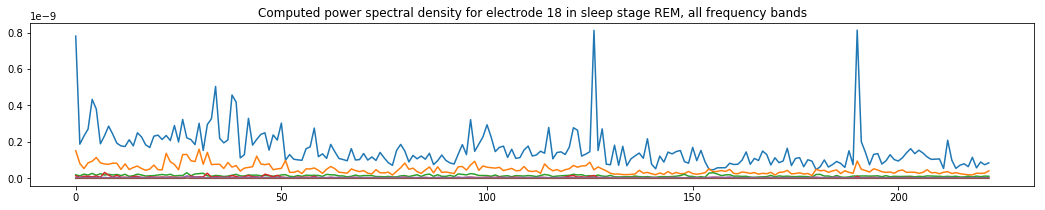

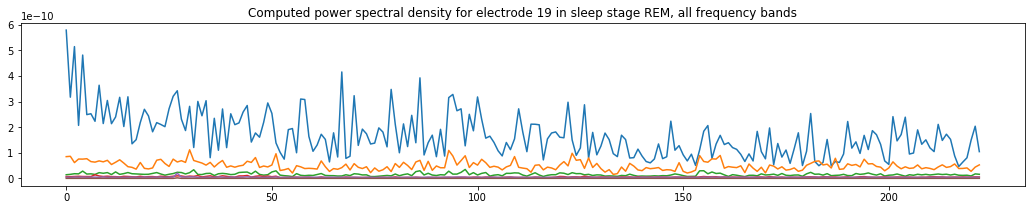

In [8]:
psd_computed = power_spectral_density(stages[STAGE], bands=True)

for electrode in range(stages[STAGE].shape[0]):
    plt.figure(figsize=(18, 3))
    plt.title(f'Computed power spectral density for electrode {electrode} in sleep stage {STAGE}, all frequency bands')
    plt.plot(psd_computed[electrode])
    plt.show()

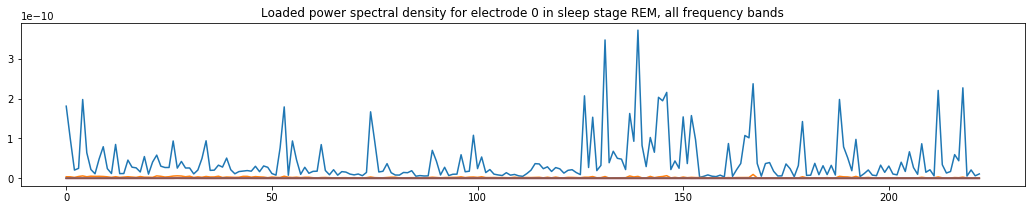

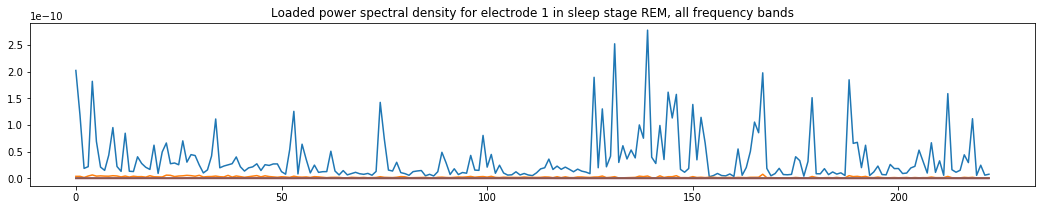

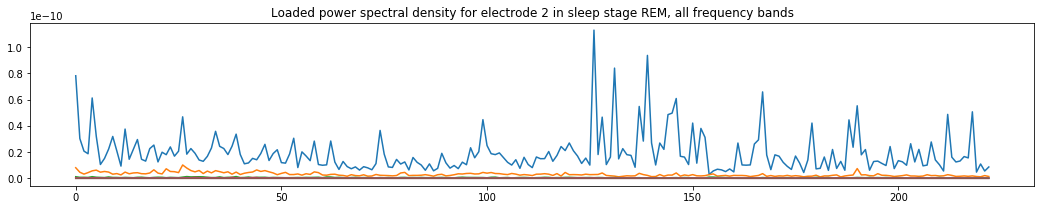

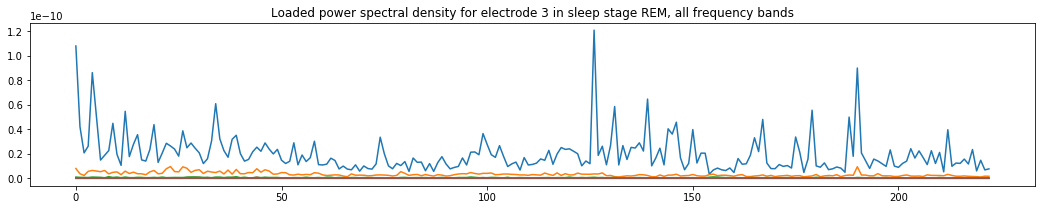

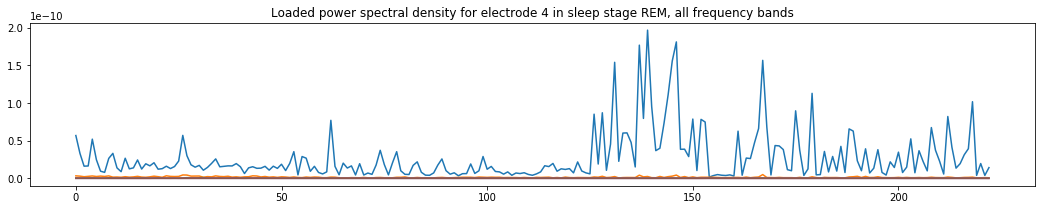

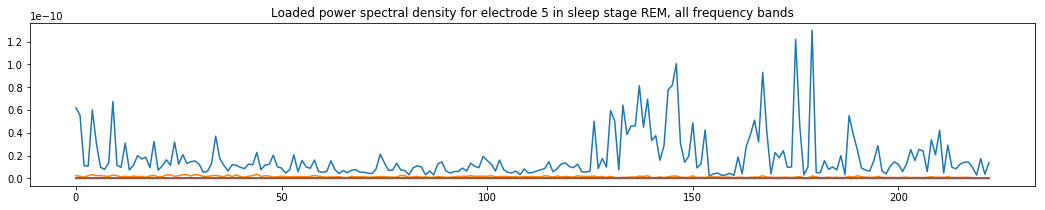

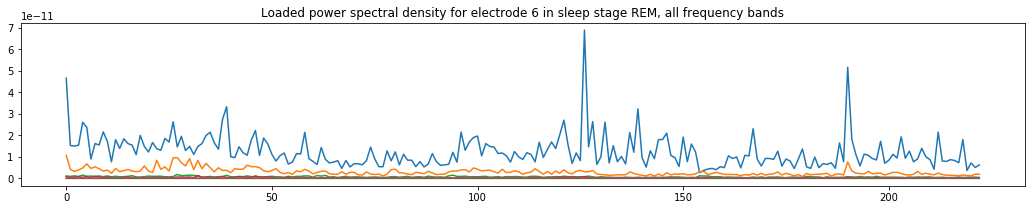

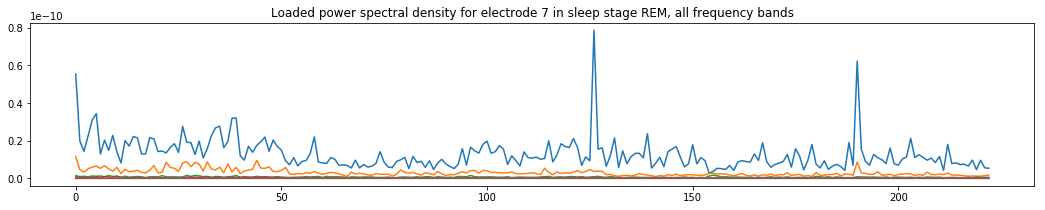

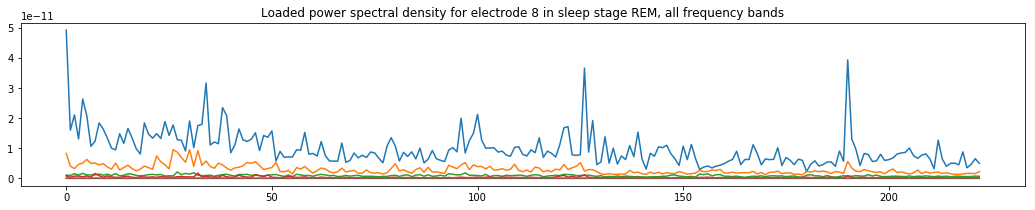

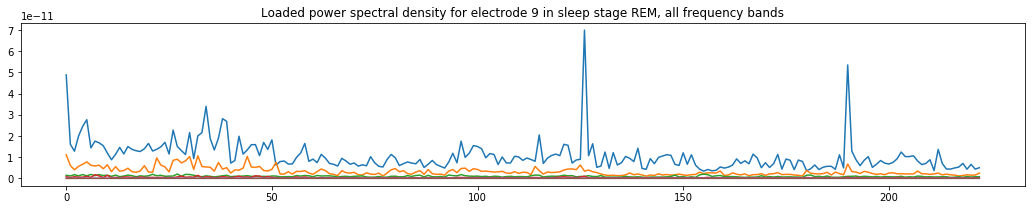

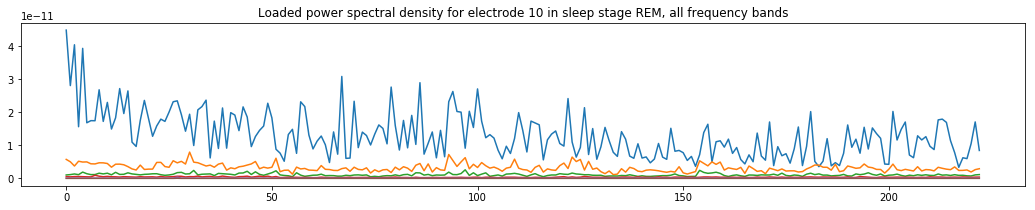

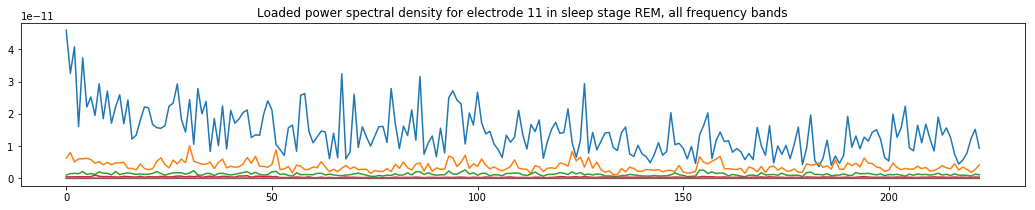

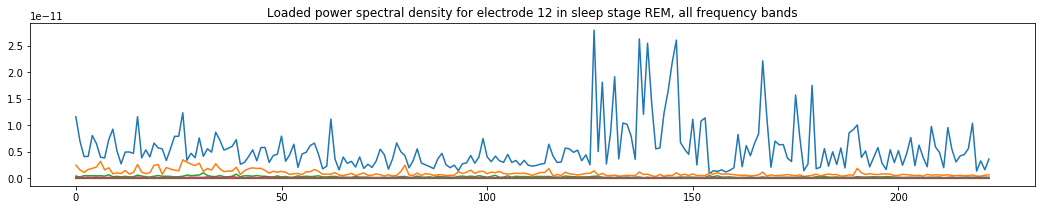

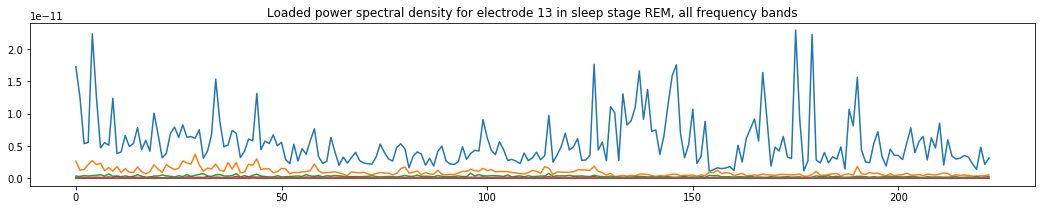

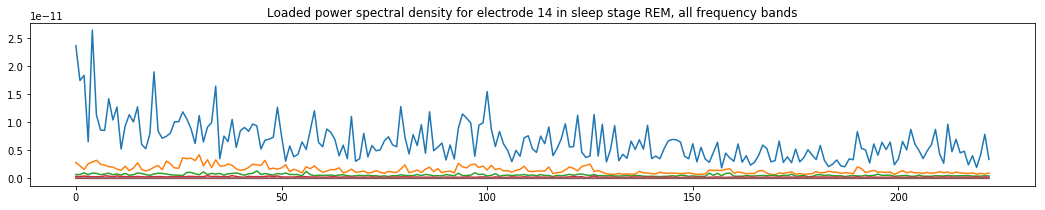

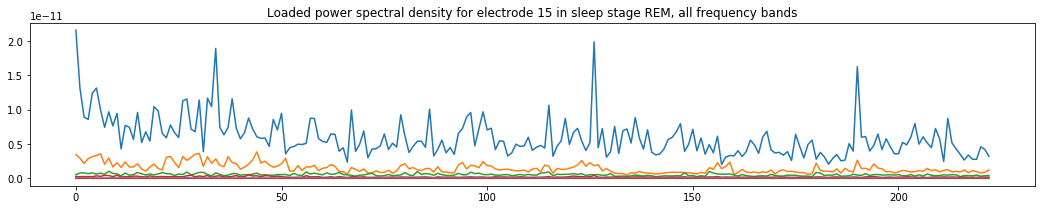

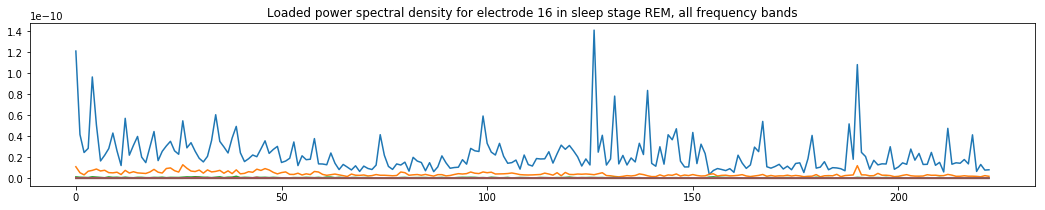

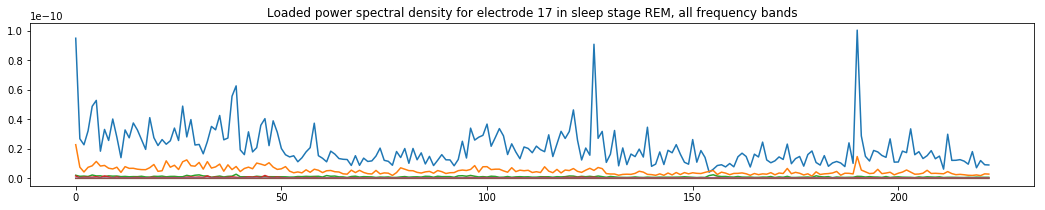

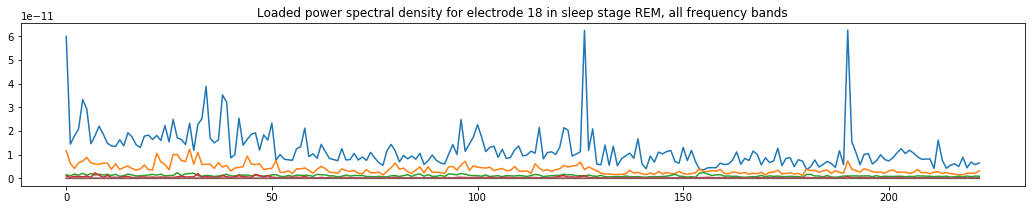

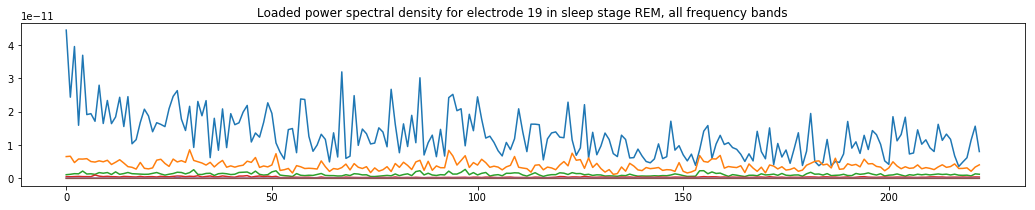

In [9]:
subject = subjects['Subject_id'][SUBJECT_INDEX]
psd_loaded = np.load(f'E:\\Cafeine_data\\CAF_{CAF_DOSE}\\PSD\\{subject}\\PSD_{STAGE}_all_bands.npy')

for electrode in range(psd_loaded.shape[2]):
    plt.figure(figsize=(18, 3))
    plt.title(f'Loaded power spectral density for electrode {electrode} in sleep stage {STAGE}, all frequency bands')
    
    for band in range(psd_loaded.shape[0]):
        plt.plot(psd_loaded[band,:,electrode])
    plt.show()

In [10]:
tolerance = 1e-7
is_close = np.allclose(psd_computed, np.reshape(psd_loaded, psd_computed.shape), atol=tolerance, rtol=0)
print(f'Are the generated PSD values close to the saved ones within a tolerance of {tolerance}? {is_close}')

Are the generated PSD values close to the saved ones within a tolerance of 1e-07? True


# Entropy

In [11]:
def shannon_entropy(signal, normalize=False):
    """
    Computes the shannon entropy for a single epoch.
    
    Args:
        signal: vector containing the signal over which the entropy is computed
        normalize: boolean indicating if the entropy value should be normalized to the range between 0 and 1
    
    Returns:
        shannon entropy as float
    """
    # normalize the signal to a probability distribution
    signal /= np.sum(signal)
    # calculate shannon entropy
    entropy = -np.sum(signal * np.log(signal))
    
    if normalize:
        # normalize entropy to range between 0 and 1
        entropy /= np.log(len(signal))
    return entropy

def permutation_entropy(signal, order=3, delay=1, normalize=False):
    """
    Computes the permutation entropy for a single epoch.
    
    Args:
        signal: vector containing the signal over which the entropy is computed
        order: permutation window length
        delay: step between the permutation windows
        normalize: boolean indicating if the entropy value should be normalized to the range between 0 and 1
    
    returns:
        permutation entropy as float
    """
    window_count = len(signal) - (order - 1) * delay
    # partition the signal into windows of length order with step size delay
    windows = np.array([signal[i*delay:i*delay+window_count] for i in range(order)]).T
    
    # calculate element ranks for each window in ascending order
    # same values become distinct ranks corresponding to the order of appearance
    # e.g. window [4, 6, 1] becomes [1, 2, 0]
    ranks = np.array([stats.rankdata(window, method='ordinal') - 1 for window in windows])
    # get relative frequency of each unique rank in the data
    rel_permutation_counts = np.unique(ranks, axis=0, return_counts=True)[1] / ranks.shape[0]
    
    # calculate permutation entropy
    entropy = -np.sum([perm * np.log2(perm) for perm in rel_permutation_counts])
    
    if normalize:
        # normalize entropy to range between 0 and 1
        entropy /= np.log2(np.math.factorial(order))
    return entropy

def sample_entropy(signal, dimension=2, tolerance=0.2):
    """Calculates the sample entropy of degree m of a signal.
    This method uses chebychev norm.
    It is quite fast for random data, but can be slower is there is
    structure in the input time series.
    Args:
        signal: numpy array of time series
        dimension: length of longest template vector
        tolerance: tolerance (defaults to 0.1 * std(signal)))
    Returns:
        Array of sample entropies:
            SE[k] is ratio "#templates of length k+1" / "#templates of length k"
            where #templates of length 0" = n*(n - 1) / 2, by definition
    Note:
        The parameter 'dimension' is equal to m + 1 in Ref[1].
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    #The code below follows the sample length convention of Ref [1] so:
    M = dimension - 1;

    signal = np.array(signal)
    if tolerance is None:
        tolerance = 0.1 * np.std(signal)
    else:
        tolerance = tolerance * np.std(signal)

    n = len(signal)

    #Ntemp is a vector that holds the number of matches. N[k] holds matches templates of length k
    Ntemp = np.zeros(M + 2)
    #Templates of length 0 matches by definition:
    Ntemp[0] = n*(n - 1) / 2


    for i in range(n - M - 1):
        template = signal[i:(i+M+1)];#We have 'M+1' elements in the template
        rem_signal = signal[i+1:]

        searchlist = np.nonzero(np.abs(rem_signal - template[0]) < tolerance)[0]

        go = len(searchlist) > 0;

        length = 1;

        Ntemp[length] += len(searchlist)

        while go:
            length += 1
            nextindxlist = searchlist + 1;
            nextindxlist = nextindxlist[nextindxlist < n - 1 - i]#Remove candidates too close to the end
            nextcandidates = rem_signal[nextindxlist]
            hitlist = np.abs(nextcandidates - template[length-1]) < tolerance
            searchlist = nextindxlist[hitlist]

            Ntemp[length] += np.sum(hitlist)

            go = any(hitlist) and length < M + 1

    sampen = -np.log(Ntemp[1:] / Ntemp[:-1])
    return sampen[-1]

def _distance(x1, x2):
    return np.max(np.abs(x1 - x2))

def _sample_entropy_slow(signal, dimension=2, tolerance=0.2):
    tolerance = tolerance * np.std(signal)
    
    embeddings = np.array([signal[i:i+dimension+1] for i in range(len(signal) - dimension)])
    matches = np.sum([np.sum([[_distance(template[:-1], embedding[:-1]) <= tolerance, _distance(template, embedding) <= tolerance] for j, embedding in enumerate(embeddings) if i != j], axis=0) for i, template in enumerate(embeddings)], axis=0)
    
    return -np.log(matches[1] / matches[0])

def spectral_entropy(stage, method='shannon'):
    """
    Computes the spectral entropy for one sleep stage using the specified entropy method (permutation or shannon).
    
    Args:
        stage: EEG data over which the spectral entropy should be computed (electrodes x epoch steps x epochs)
        method: string indicating which entropy method to be used (shannon, permutation or sample)
    
    Returns:
        spectral entropy of the sleep stage (electrodes x epochs)
    """
    # compute power spectral density
    psd = power_spectral_density(stage, bands=False)
    
    electrode_count = psd.shape[0]
    epoch_count = psd.shape[1]
    
    spec_entropy = np.empty((electrode_count, epoch_count))
    for electrode in range(electrode_count):
        for epoch in range(epoch_count):
            if method.lower() == 'shannon':
                # get PSD shannon entropy for the current electrode and epoch
                spec_entropy[electrode,epoch] = shannon_entropy(psd[electrode,epoch], normalize=True)
            elif method.lower() == 'permutation':
                # get PSD permutation entropy for the current electrode and epoch 
                spec_entropy[electrode,epoch] = permutation_entropy(psd[electrode,epoch], normalize=True)
            elif method.lower() == 'sample':
                # get PSD sample entropy for the current electrode and epoch
                spec_entropy[electrode,epoch] = sample_entropy(psd[electrode,epoch])
            else:
                # unknown entropy method
                raise NotImplementedError(f'Entropy type "{method}" is unknown')
    return spec_entropy

In [34]:
samp_spec_stages = {}
for name, curr_stage in stages.items():
    print(f'Calculating spectral sample entropy for sleep stage {name}...')
    samp_spec_stages[name] = spectral_entropy(curr_stage, method='sample')

Calculating spectral sample entropy for sleep stage AWA...
Calculating spectral sample entropy for sleep stage N1...
Calculating spectral sample entropy for sleep stage N2...
Calculating spectral sample entropy for sleep stage N3...
Calculating spectral sample entropy for sleep stage REM...


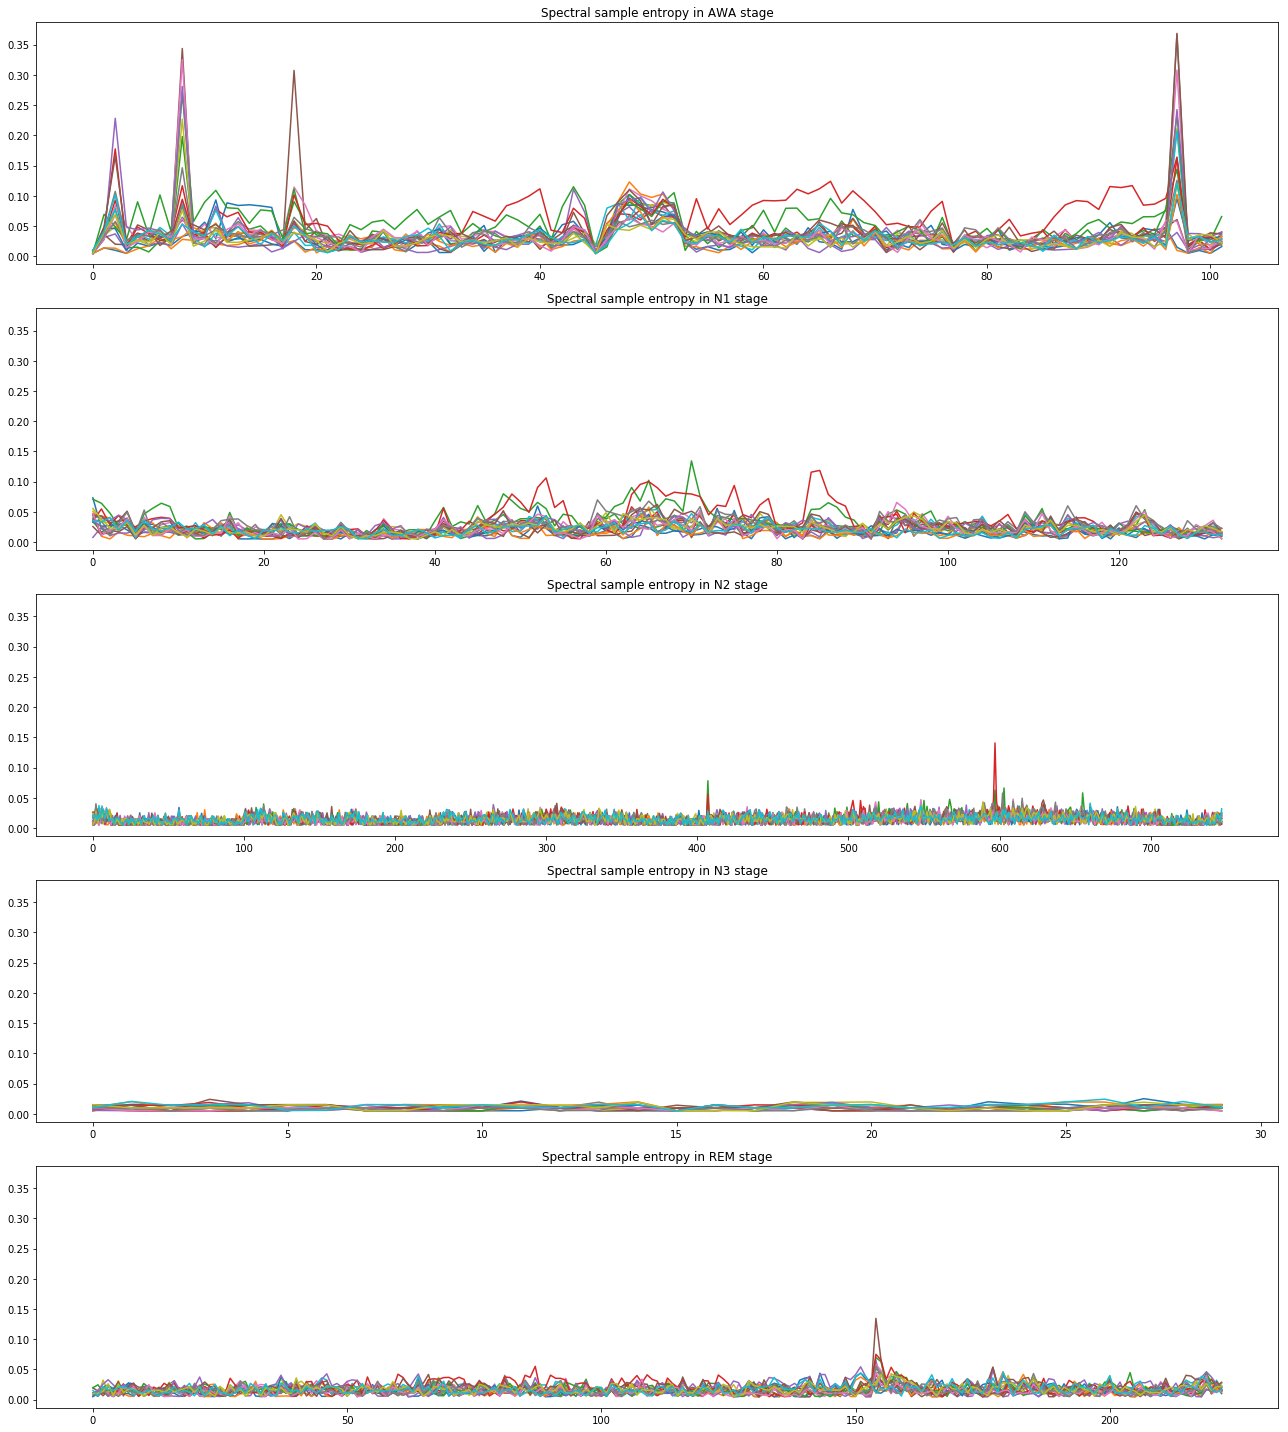

In [35]:
last_ax = None
plt.figure(figsize=(18, 20))

for i, (name, curr_spec) in enumerate(samp_spec_stages.items()):
    last_ax = plt.subplot(len(samp_spec_stages.keys()), 1, i + 1, sharey=last_ax)
    plt.title(f'Spectral sample entropy in {name} stage')
    plt.plot(curr_spec.T)

plt.tight_layout()
plt.show()

In [36]:
perm_spec_stages = {}
for name, curr_stage in stages.items():
    print(f'Calculating spectral permutation entropy for sleep stage {name}...')
    perm_spec_stages[name] = spectral_entropy(curr_stage, method='permutation')

Calculating spectral permutation entropy for sleep stage AWA...
Calculating spectral permutation entropy for sleep stage N1...
Calculating spectral permutation entropy for sleep stage N2...
Calculating spectral permutation entropy for sleep stage N3...
Calculating spectral permutation entropy for sleep stage REM...


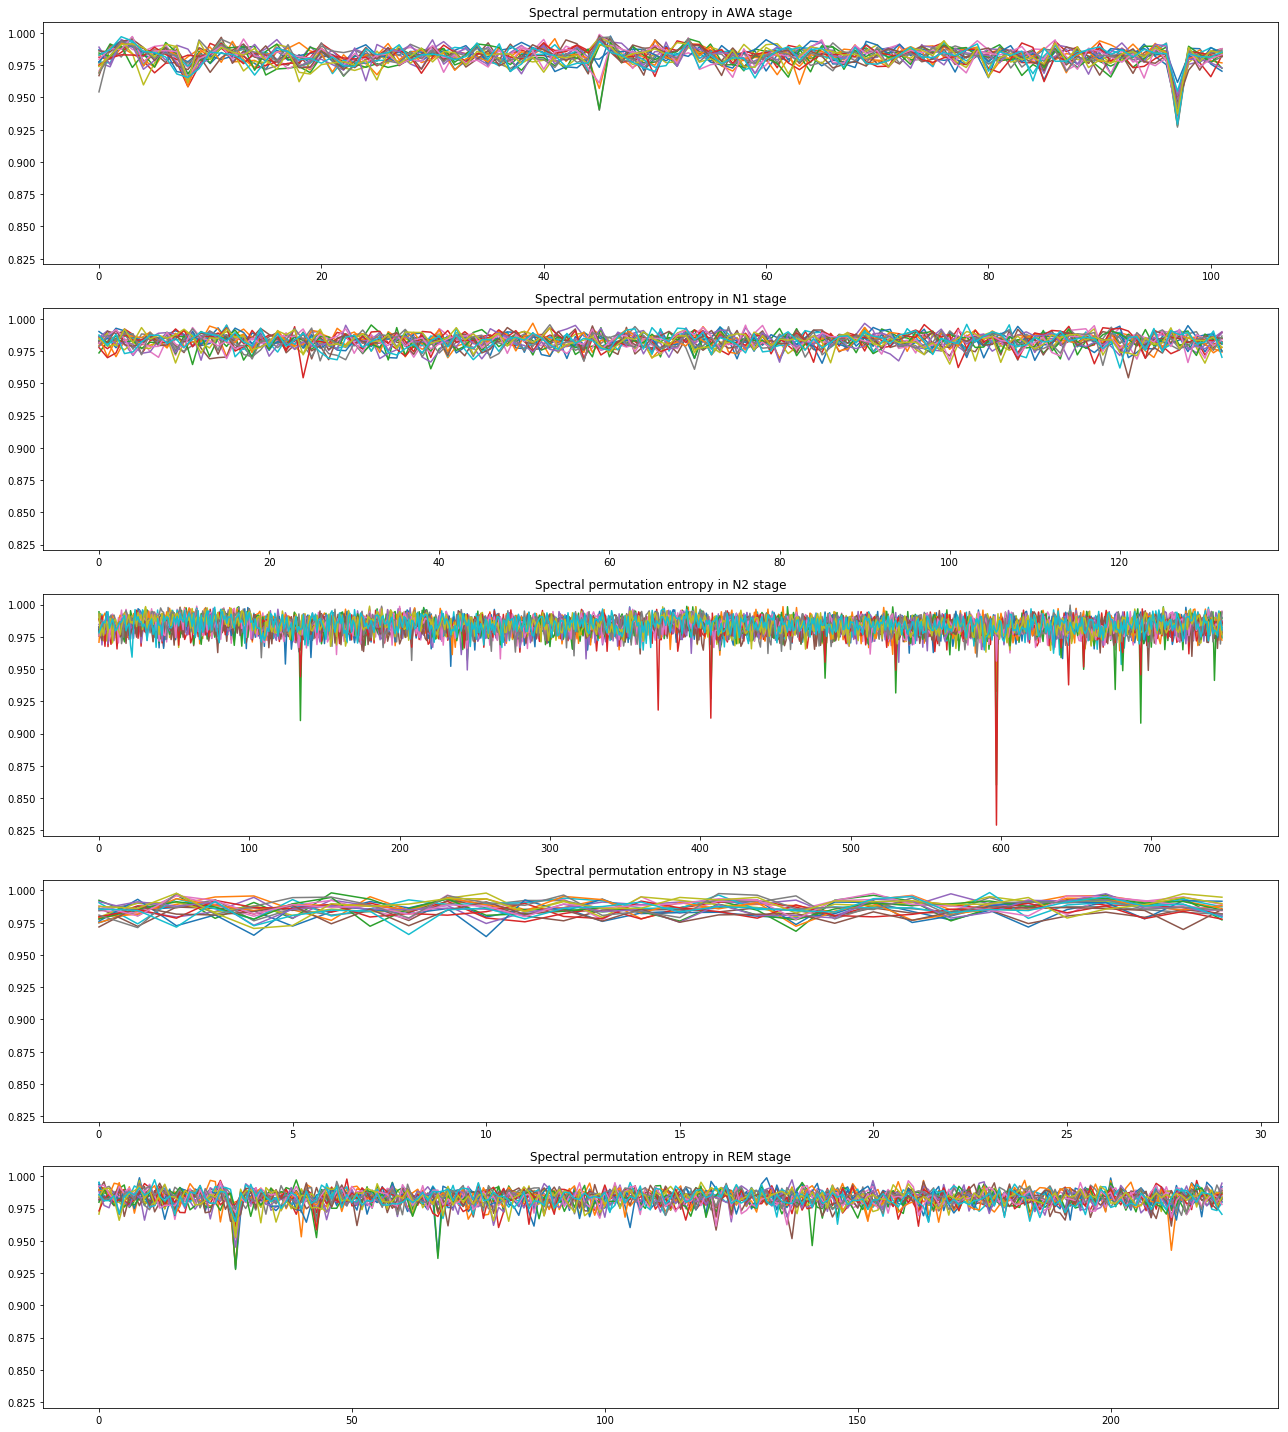

In [37]:
last_ax = None
plt.figure(figsize=(18, 20))

for i, (name, curr_spec) in enumerate(perm_spec_stages.items()):
    last_ax = plt.subplot(len(perm_spec_stages.keys()), 1, i + 1, sharey=last_ax)
    plt.title(f'Spectral permutation entropy in {name} stage')
    plt.plot(curr_spec.T)

plt.tight_layout()
plt.show()

In [38]:
shan_spec_stages = {}
for name, curr_stage in stages.items():
    print(f'Calculating spectral shannon entropy for sleep stage {name}...')
    shan_spec_stages[name] = spectral_entropy(curr_stage, method='shannon')

Calculating spectral shannon entropy for sleep stage AWA...
Calculating spectral shannon entropy for sleep stage N1...
Calculating spectral shannon entropy for sleep stage N2...
Calculating spectral shannon entropy for sleep stage N3...
Calculating spectral shannon entropy for sleep stage REM...


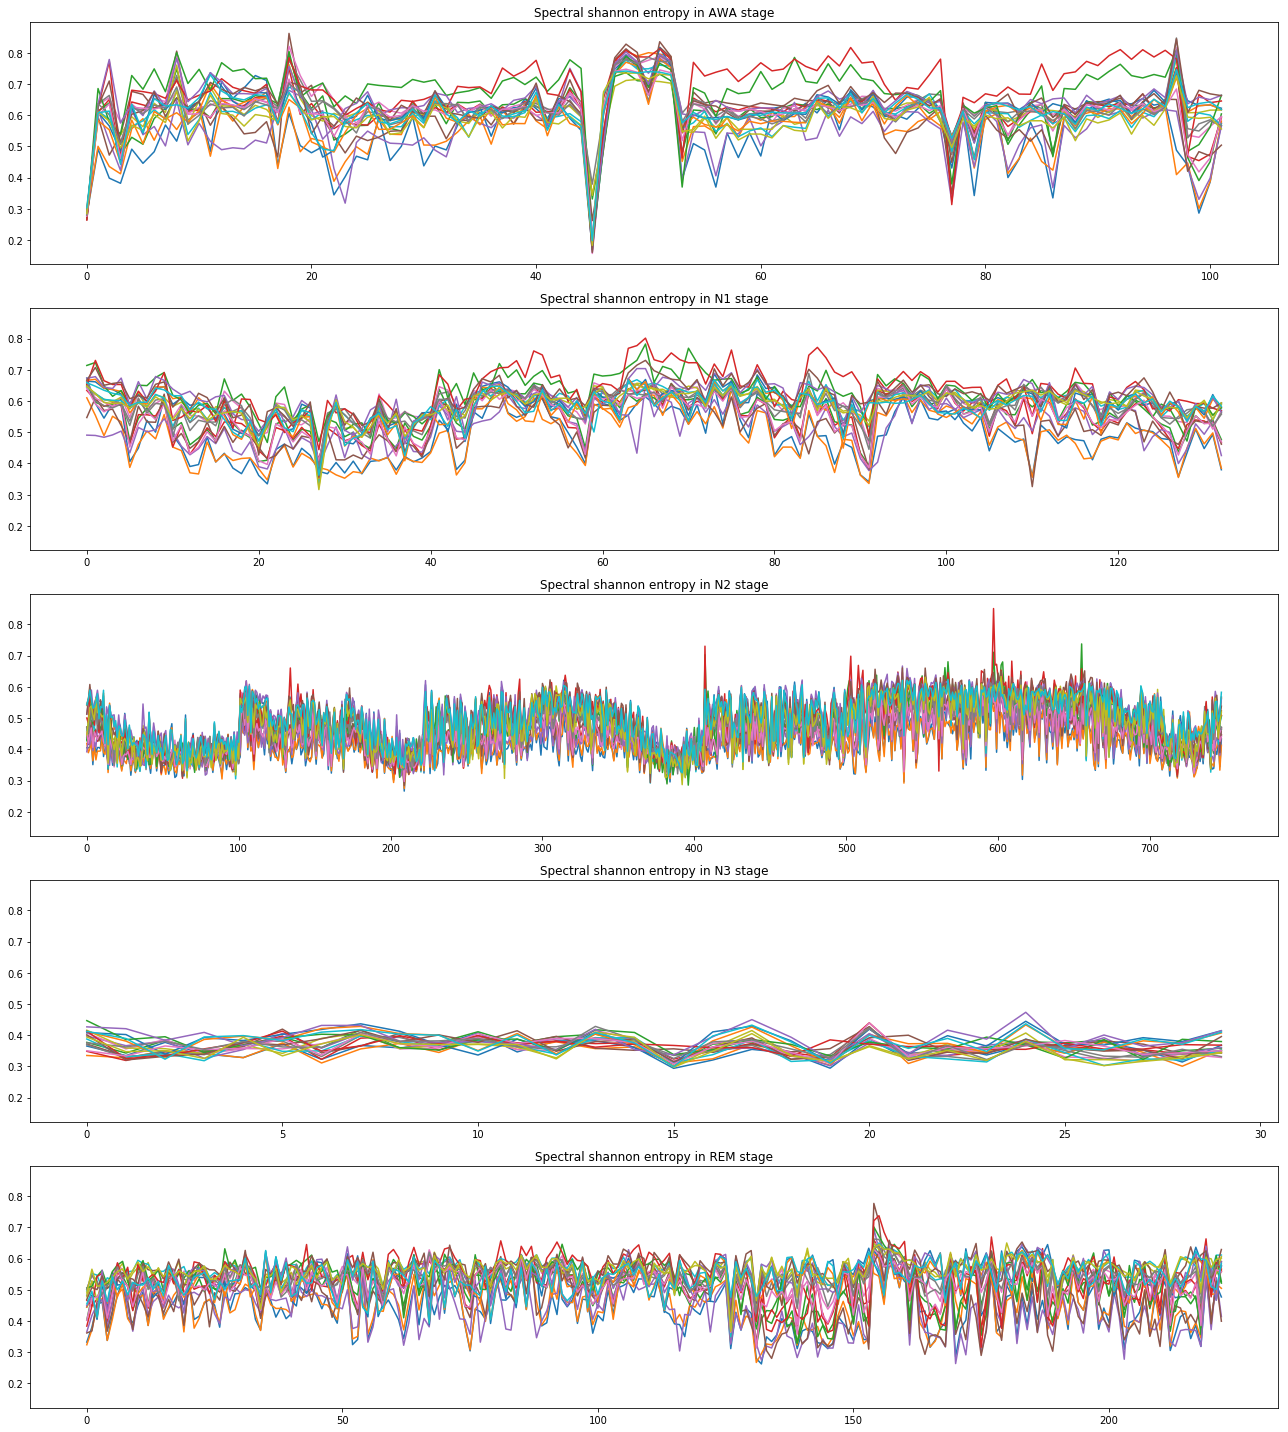

In [39]:
plt.figure(figsize=(18, 20))

last_ax = None
for i, (name, curr_spec) in enumerate(shan_spec_stages.items()):
    last_ax = plt.subplot(len(shan_spec_stages.keys()), 1, i + 1, sharey=last_ax)
    plt.title(f'Spectral shannon entropy in {name} stage')
    plt.plot(curr_spec.T)

plt.tight_layout()
plt.show()

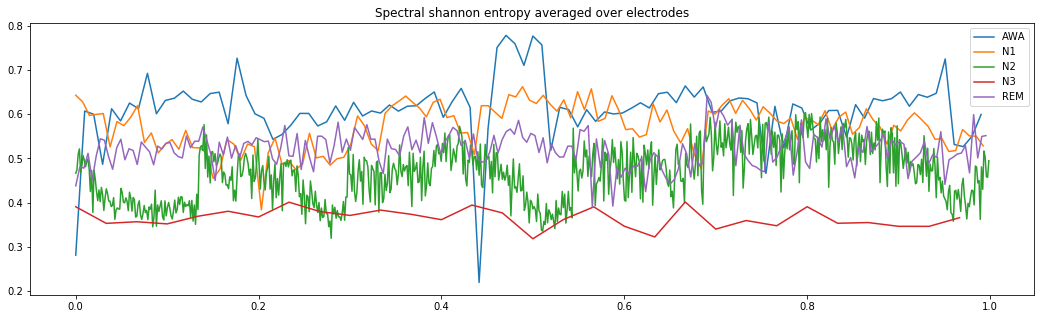

In [40]:
plt.figure(figsize=(18, 5))
plt.title('Spectral shannon entropy averaged over electrodes')
for name, curr in shan_spec_stages.items():
    plt.plot(np.arange(curr.shape[1]) / curr.shape[1], curr.mean(axis=0), label=name)
plt.legend()
plt.show()

### Saved vs computed spectral entropy comparison

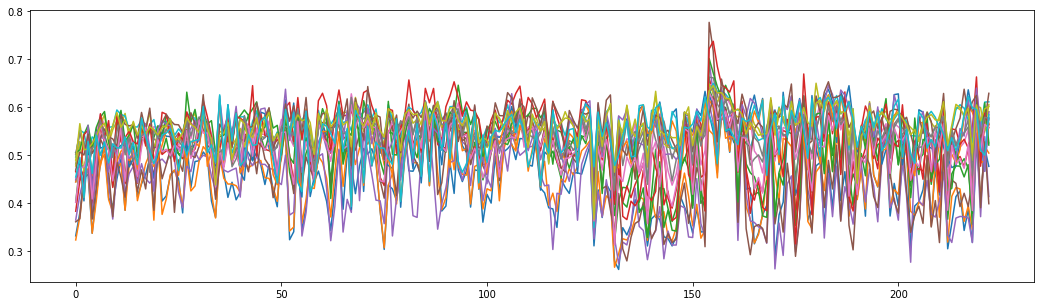

In [23]:
se_computed = spectral_entropy(stages[STAGE], method='shannon')

plt.figure(figsize=(18, 5))
plt.plot(se_computed.T)
plt.show()

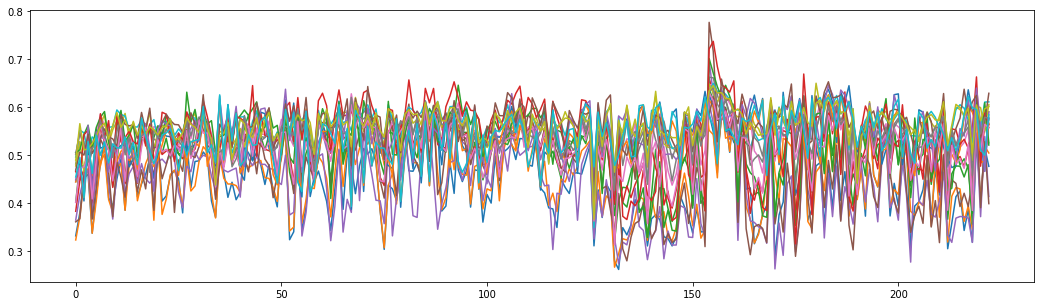

In [24]:
subject = subjects['Subject_id'][SUBJECT_INDEX]
se_loaded = np.load(f'E:\\Cafeine_data\\CAF_{CAF_DOSE}\\SpecEntropy\\{subject}\\SpecEntropy_{STAGE}.npy')

plt.figure(figsize=(18, 5))
plt.plot(se_loaded)
plt.show()

In [25]:
tolerance = 1e-3
is_close = np.allclose(se_computed, se_loaded.T, atol=tolerance, rtol=0)
print(f'Are the generated spectral entropy values close to the saved ones within a tolerance of {tolerance}? {is_close}')

Are the generated spectral entropy values close to the saved ones within a tolerance of 0.001? True


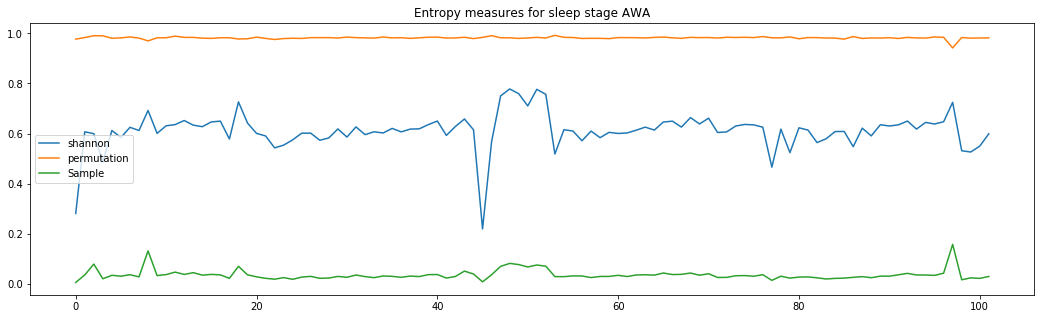

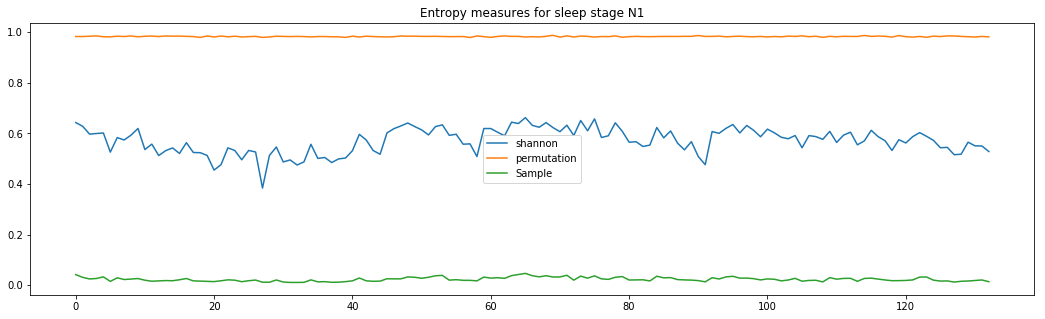

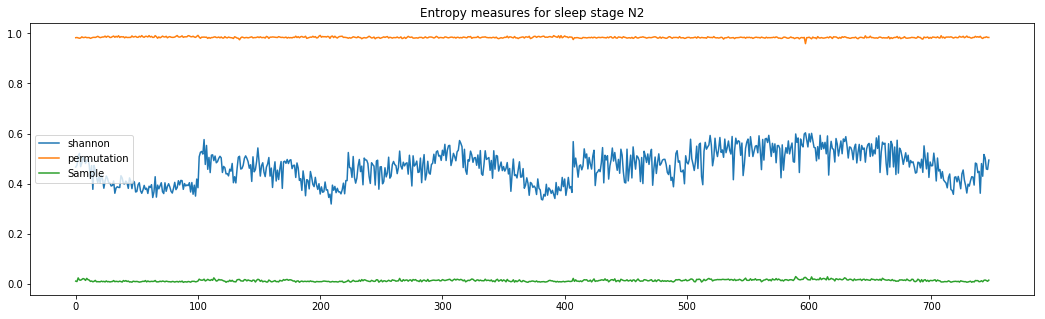

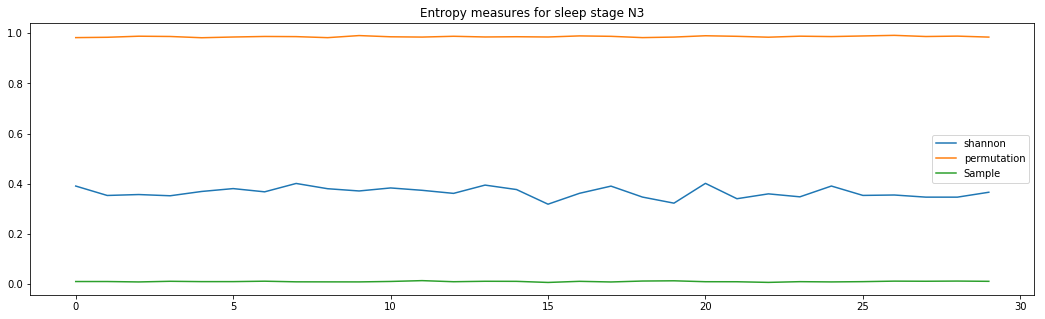

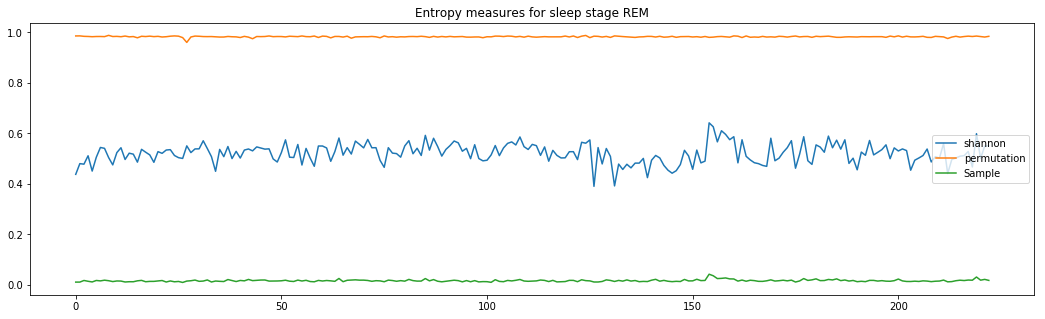

In [41]:
for key in shan_spec_stages.keys():
    plt.figure(figsize=(18, 5))
    plt.title(f'Entropy measures for sleep stage {key}')
    plt.plot(shan_spec_stages[key].mean(axis=0), label='shannon')
    plt.plot(perm_spec_stages[key].mean(axis=0), label='permutation')
    plt.plot(samp_spec_stages[key].mean(axis=0), label='Sample')
    plt.legend()
    plt.show()

In [27]:
shan_entr = np.empty((stages[STAGE].shape[0], stages[STAGE].shape[2]))
for electrode in range(stages[STAGE].shape[0]):
    for epoch in range(stages[STAGE].shape[2]):
        shan_entr[electrode, epoch] = shannon_entropy(np.abs(stages[STAGE][electrode,:,epoch]), normalize=True)

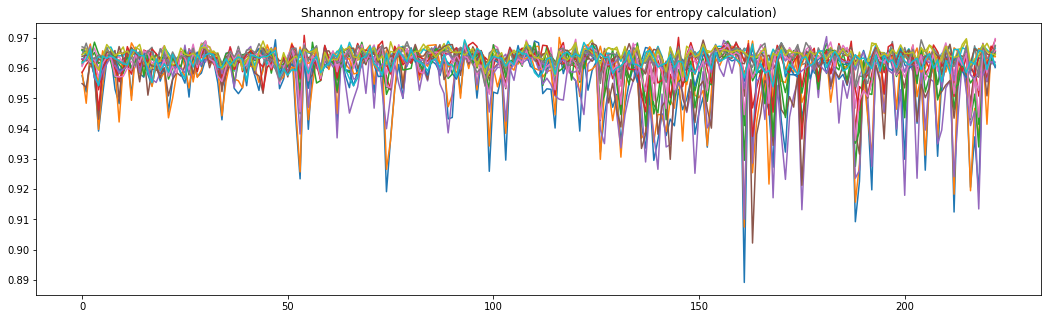

In [28]:
plt.figure(figsize=(18, 5))
plt.title(f'Shannon entropy for sleep stage {STAGE} (absolute values for entropy calculation)')
plt.plot(shan_entr.T)
plt.show()

In [29]:
perm_entr = np.empty((stages[STAGE].shape[0], stages[STAGE].shape[2]))
for electrode in range(stages[STAGE].shape[0]):
    print(electrode)
    for epoch in range(stages[STAGE].shape[2]):
        perm_entr[electrode, epoch] = permutation_entropy(stages[STAGE][electrode,:,epoch], normalize=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


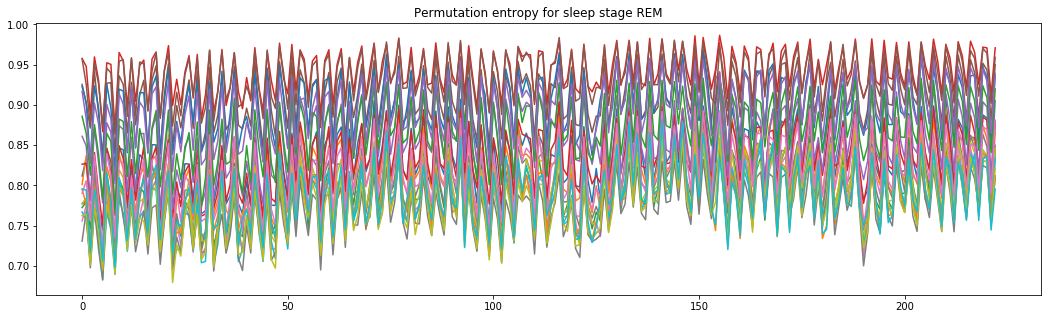

In [30]:
plt.figure(figsize=(18, 5))
plt.title(f'Permutation entropy for sleep stage {STAGE}')
plt.plot(perm_entr.T)
plt.show()

In [31]:
samp_entr = np.empty((stages[STAGE].shape[0], stages[STAGE].shape[2]))
for electrode in range(stages[STAGE].shape[0]):
    print(electrode)
    for epoch in range(stages[STAGE].shape[2]):
        samp_entr[electrode, epoch] = sample_entropy(stages[STAGE][electrode,:,epoch])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


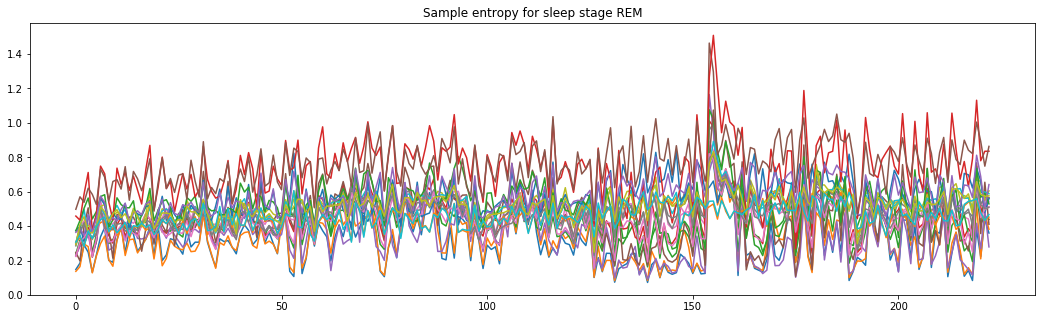

In [32]:
plt.figure(figsize=(18, 5))
plt.title(f'Sample entropy for sleep stage {STAGE}')
plt.plot(samp_entr.T)
plt.show()

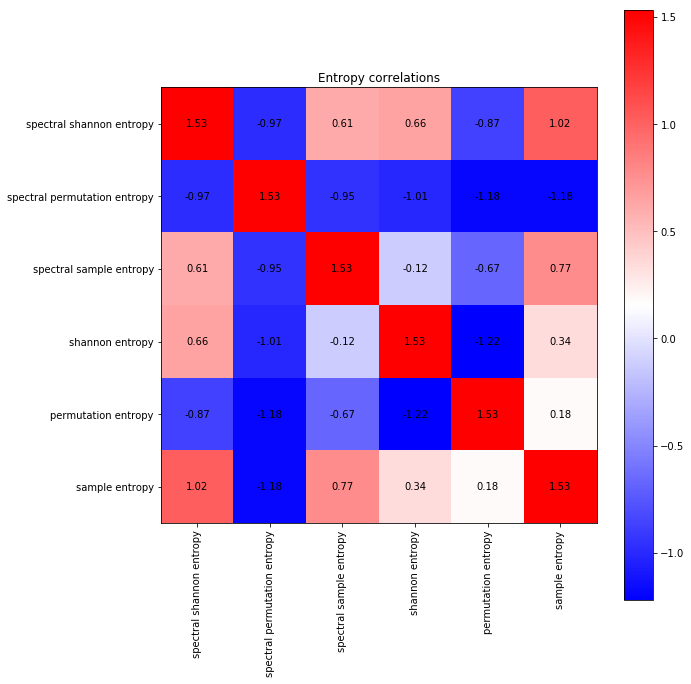

In [42]:
names = ['spectral shannon entropy', 'spectral permutation entropy', 'spectral sample entropy',
         'shannon entropy', 'permutation entropy', 'sample entropy']
entropies = [shan_spec_stages[STAGE], perm_spec_stages[STAGE], samp_spec_stages[STAGE],
             shan_entr, perm_entr, samp_entr]

corr = np.empty((len(entropies), len(entropies)))
for i in range(len(entropies)):
    for j in range(len(entropies)):
        e1 = entropies[i].mean(axis=0)
        e2 = entropies[j].mean(axis=0)
        corr[i,j] = np.correlate((e1 - e1.mean()) / e1.std(), (e2 - e2.mean()) / e2.std())

corr = (corr - corr.mean()) / corr.std()
        
_, ax = plt.subplots(figsize=(10, 10))
plt.title('Entropy correlations')
plt.imshow(corr, cmap='bwr')

for x in range(len(corr)):
    for y in range(len(corr[x])):
        ax.text(x, y, f'{corr[x,y]:.2f}', ha='center', va='center')

plt.xticks(np.arange(len(names)), names, rotation=90)
plt.yticks(np.arange(len(names)), names)
plt.colorbar()
plt.tight_layout()
plt.show()

# Other

In [ ]:
subjects = pd.read_csv(SUBJECTS_PATH, index_col=0)

for i, subject in enumerate(subjects['Subject_id']):
    break
    print(f'Processing file "{subject}" ({(i + 1) / subjects.shape[0] * 100:.2f}%)')
    
    # load cleaned EEG data
    data_path = os.path.join(DATA_PATH, subject, 'EEG_data_clean.npy')
    data = np.load(data_path)
    
    # load cleaned hypnogram data
    hypnogram_path = os.path.join(DATA_PATH, subject, 'hyp_clean.npy')
    hypnogram = np.load(hypnogram_path)

    stages = extract_sleep_stages(data, hypnogram)